# Intro to Variational Autoencoder 

A variational autoencoder is a generative model.

## Prepare Dataset

In [1]:
import numpy as np
from keras.datasets import mnist

def get_dataset():
    # Load dataset
    (x_train, _), (x_test, _) = mnist.load_data()

    # Normalize data
    x_train = x_train.astype('float32')/255
    x_test = x_test.astype('float32')/255

    # Flatten images into 1D array
    # x_train.shape = (num_images, width, height) to (num_image, width*height)
    # x_test.shape = (num_images, width, height) to (num_image, width*height)
    image_shape = x_train.shape[1:]
    total_pixel = np.prod(image_shape)

    num_training = x_train.shape[0]
    num_test = x_test.shape[0]

    x_train = x_train.reshape(num_training, total_pixel)
    x_test = x_test.reshape(num_test, total_pixel)

    return x_train, x_test

x_train, x_test = get_dataset()
print('Num examples ', x_train.shape[0])

Num examples  60000


## Visualization

<Figure size 432x288 with 0 Axes>

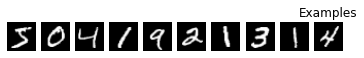

In [2]:
import matplotlib.pyplot as plt

def show_images(data, title):
    plt.gray()
    fig, ax = plt.subplots(1, 10)
    for i in range(10):
        ax[i].axis('off')
        ax[i].imshow(data[i].reshape(28, 28))
    plt.title(title)

show_images(x_train, 'Examples')

## Create Model

In [3]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.losses import binary_crossentropy
from keras import backend as K

DIGIT_SIZE = 28
ORIGIN_DIM = DIGIT_SIZE**2
LATENT_DIM = 2
HIDDEN_DIM = 521

def sampling_z(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0] # should be BATCH_SIZE
    dim = K.int_shape(z_mean)[1] # should be LATENT_DIM
    epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def get_variational_autoencoder():
    # Decoder Layers (From ORIGIN_DIM to 2)
    input_layer = Input(shape=(ORIGIN_DIM,))
    encoder_layer = Dense(units=HIDDEN_DIM, activation='relu', name='encoder_layer')(input_layer)

    z_mean_layer = Dense(units=LATENT_DIM, activation = 'linear', name='z_mean')(encoder_layer)
    z_log_var_layer  = Dense(units=LATENT_DIM, activation = 'linear', name='z_log_var')(encoder_layer)
    z_layer = Lambda(sampling_z, output_shape=(LATENT_DIM,), name='z')([z_mean_layer, z_log_var_layer])

    # Encoder Layers (From 2 to ORIGIN_DIM)
    # From 2 to 784
    decoder_layer = Dense(units=HIDDEN_DIM, activation='relu', name='decoder_layer')
    decoder_out_layer = Dense(units=ORIGIN_DIM, activation='sigmoid', name='decoder_out')

    tmp_layer = decoder_layer(z_layer)
    output_layer = decoder_out_layer(tmp_layer)

    # VAE model + Loss function
    # Shameless copy-paste from https://keras.io/examples/variational_autoencoder/
    vae = Model(input_layer, output_layer, name='vae')
    reconstruction_loss = binary_crossentropy(input_layer, output_layer)
    reconstruction_loss *= ORIGIN_DIM
    kl_loss = 1 + z_log_var_layer - K.square(z_mean_layer) - K.exp(z_log_var_layer)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

    # decoder model
    decoder_input = Input(shape=(LATENT_DIM,))
    decoder_hidden_layer = decoder_layer(decoder_input)
    decoder_out_layer = decoder_out_layer(decoder_hidden_layer)
    decoder = Model(decoder_input, decoder_out_layer, name='decoder')

    return decoder, vae

## Training

Epoch 1/10
600/600 [==============================] - 3s 5ms/step - loss: 191.2326 - val_loss: 169.8824
Epoch 2/10
600/600 [==============================] - 3s 4ms/step - loss: 167.3602 - val_loss: 165.4895
Epoch 3/10
600/600 [==============================] - 3s 4ms/step - loss: 163.8737 - val_loss: 163.0455
Epoch 4/10
600/600 [==============================] - 3s 5ms/step - loss: 161.6322 - val_loss: 161.1641
Epoch 5/10
600/600 [==============================] - 3s 4ms/step - loss: 159.8846 - val_loss: 159.6808
Epoch 6/10
600/600 [==============================] - 3s 5ms/step - loss: 158.4640 - val_loss: 158.4353
Epoch 7/10
600/600 [==============================] - 3s 5ms/step - loss: 157.3081 - val_loss: 157.6575
Epoch 8/10
600/600 [==============================] - 3s 5ms/step - loss: 156.3640 - val_loss: 156.7198
Epoch 9/10
600/600 [==============================] - 3s 5ms/step - loss: 155.4887 - val_loss: 155.8659
Epoch 10/10
600/600 [==============================] - 3s 5ms/st

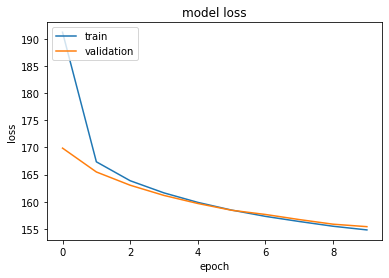

In [4]:
EPOCH = 10
BATCH_SIZE = 100

decoder, vae = get_variational_autoencoder()
x_train, x_test = get_dataset()

history = vae.fit(x_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCH,
        shuffle=True,
        verbose=1,
        validation_data=(x_test, None))

# plot accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Result

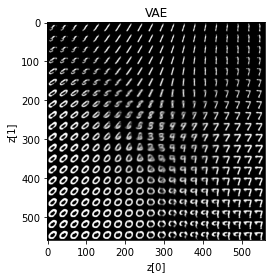

In [6]:
def show_result(decoder):
    NUM_DIGIT_X = 20
    NUM_DIGIT_Y = 20
    grid_x = np.linspace(-5, 5, NUM_DIGIT_X)
    grid_y = np.linspace(-5, 5, NUM_DIGIT_Y)
    
    # Predicted image
    figure = np.zeros((DIGIT_SIZE * NUM_DIGIT_X, DIGIT_SIZE * NUM_DIGIT_Y))
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(DIGIT_SIZE, DIGIT_SIZE)
            figure[i * DIGIT_SIZE: (i + 1) * DIGIT_SIZE,
                   j * DIGIT_SIZE: (j + 1) * DIGIT_SIZE] = digit

    plt.figure()
    plt.gray()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.title('VAE')
    plt.show()
    
show_result(decoder)

## Resources

- Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes." arXiv preprint arXiv:1312.6114 (2013).